In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame,Series
import seaborn as sns
import matplotlib.pyplot as plt
from catboost.core import CatBoostClassifier
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GroupShuffleSplit
import shap
from xgboost import XGBClassifier,plot_importance


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

input/test.csv
input/train.csv
input/gender_submission.csv


In [34]:
#load data and examin size
train_data = pd.read_csv("input/train.csv")
test_data = pd.read_csv("input/test.csv")
print(f"train data shape {train_data.shape}")
print("train data columns" , train_data.columns)
print(f"test data shape {test_data.shape}")
print("test data columns" , test_data.columns)

train data shape (891, 12)
train data columns Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
test data shape (418, 11)
test data columns Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [35]:
#analysis features
print("distinct siblings", train_data['SibSp'].unique())
print("distinct Parch", train_data['Parch'].unique())
print("distinct Sex", train_data['Sex'].unique())
print(train_data['SibSp'].value_counts())
print(train_data['Parch'].value_counts())
print(train_data['Survived'].value_counts())
print(train_data.columns)

distinct siblings [1 0 3 4 2 5 8]
distinct Parch [0 1 2 5 3 4 6]
distinct Sex ['male' 'female']
SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64
Survived
0    549
1    342
Name: count, dtype: int64
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [36]:
#Filter data
train_data = train_data.drop_duplicates()
print(f"train data shape {train_data.shape}")
train_data = train_data[train_data['Survived'].notnull()]
print(f"train data shape {train_data.shape}")
train_data = train_data.drop(columns=['Name','Ticket','Cabin','Fare','Embarked'], errors='ignore')
print(f"train data shape {train_data.shape}")

sex_encoded = pd.get_dummies(train_data['Sex'],prefix='Sex',drop_first=False)
train_data['Sex']  = sex_encoded['Sex_female'].astype(int)

sex_encoded = pd.get_dummies(test_data['Sex'],prefix='Sex',drop_first=False)
test_data['Sex']  = sex_encoded['Sex_female'].astype(int)

train data shape (891, 12)
train data shape (891, 12)
train data shape (891, 7)


In [37]:
#Features and target column / Label
target_col = "Survived"
model_features = [
    "Pclass",
    "Sex",
    "Age",
    "SibSp",
    "Parch",
]

In [38]:
# create train test validation data sets 
def create_train_val_test_split(
    data: pd.DataFrame,
    target_col: str,
    group_col: str = "id",
    train_size: float = 0.64,
    val_size: float = 0.16,
    test_size: float = 0.20,
    random_state: int = 42
) -> tuple:
    """
    Splits the dataset into train, validation, and test using group-based splitting.
    Returns X and y for each split, and a stats DataFrame.
    """

    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Splits must sum to 1.0"

    X = data.drop(columns=[target_col])
    y = data[target_col]

    # First split: Train+Val vs Test
    gss1 = GroupShuffleSplit(n_splits=1, 
                             train_size=(train_size + val_size), 
                             test_size=test_size, 
                             random_state=random_state)
    train_val_idx, test_idx = next(gss1.split(X, y, groups=data[group_col]))

    train_val_data = data.iloc[train_val_idx]
    test_data = data.iloc[test_idx]

    # Second split: Train vs Val from Train+Val
    gss2 = GroupShuffleSplit(n_splits=1, train_size=train_size / (train_size + val_size),
                             test_size=val_size / (train_size + val_size), random_state=random_state)
    train_idx, val_idx = next(gss2.split(train_val_data.drop(columns=[target_col]),
                                         train_val_data[target_col],
                                         train_val_data[group_col]))

    train_data = train_val_data.iloc[train_idx]
    val_data = train_val_data.iloc[val_idx]

    # Build statistics for each split
    df_stats = pd.DataFrame({
        "Split": ["Train", "Validation", "Test"],
        "Rows": [len(train_data), len(val_data), len(test_data)],
        "Positive Rate": [
            train_data[target_col].mean(),
            val_data[target_col].mean(),
            test_data[target_col].mean()
        ]
    })

    return (
        train_data.drop(columns=[target_col]),
        train_data[target_col],
        val_data.drop(columns=[target_col]),
        val_data[target_col],
        test_data.drop(columns=[target_col]),
        test_data[target_col],
        df_stats
    )

X_train, y_train, X_val, y_val, X_test, y_test, stats = create_train_val_test_split(
    data=train_data,
    target_col=target_col,
    group_col="PassengerId",  
    train_size=0.64,
    val_size=0.16,
    test_size=0.20,
    random_state=42
)

print(stats)
print(X_train.columns)

        Split  Rows  Positive Rate
0       Train   569       0.384886
1  Validation   143       0.342657
2        Test   179       0.413408
Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch'], dtype='object')


In [39]:
#Check nulls
def print_nulls(X_train,X_val,X_test,model_features):

    datasets = {"train":X_train,"validation": X_val, "test":X_test}
    
    for name, df in datasets.items():
        print(f"\n missing values in {name} set")
        null_counts = df[model_features].isnull().sum()
        null_percent = (df[model_features].isnull().mean() * 100).round(2)

        # Combine into a readable DataFrame
        missing_report = pd.DataFrame({
            'Missing Count': null_counts,
            'Missing %': null_percent
        })
        print(missing_report)

print_nulls(X_train,X_val,X_test,model_features)


 missing values in train set
        Missing Count  Missing %
Pclass              0       0.00
Sex                 0       0.00
Age               113      19.86
SibSp               0       0.00
Parch               0       0.00

 missing values in validation set
        Missing Count  Missing %
Pclass              0       0.00
Sex                 0       0.00
Age                27      18.88
SibSp               0       0.00
Parch               0       0.00

 missing values in test set
        Missing Count  Missing %
Pclass              0       0.00
Sex                 0       0.00
Age                37      20.67
SibSp               0       0.00
Parch               0       0.00


In [40]:
# fill nulls with zero
def impute_missing_values(X_train,X_val,X_test,model_features,value):

    datasets = {"train":X_train,"validation": X_val, "test":X_test}
    
    for name, df in datasets.items():
        df[model_features] = df[model_features].fillna(value)
    return datasets     

median_age = train_data['Age'].median()
impute_missing_values(X_train,X_val,X_test,["Age"],median_age)
print_nulls(X_train,X_val,X_test,model_features)


 missing values in train set
        Missing Count  Missing %
Pclass              0        0.0
Sex                 0        0.0
Age                 0        0.0
SibSp               0        0.0
Parch               0        0.0

 missing values in validation set
        Missing Count  Missing %
Pclass              0        0.0
Sex                 0        0.0
Age                 0        0.0
SibSp               0        0.0
Parch               0        0.0

 missing values in test set
        Missing Count  Missing %
Pclass              0        0.0
Sex                 0        0.0
Age                 0        0.0
SibSp               0        0.0
Parch               0        0.0


In [41]:
def add_derived_features_with_target(X,y):
    df = pd.concat([X.copy(),y], axis=1) 

    df['AgeGroup'] = pd.cut(df['Age'],
                            bins=[0, 12, 18, 35, 60, 100],
                            labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])

    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    df['FamilyBucket'] = pd.cut(df['FamilySize'],
                                bins=[0, 1, 4, 11],  # Alone, Small (2–4), Large (5+)
                                labels=['Alone', 'Small', 'Large'])
    return df                            

data_analysis = add_derived_features_with_target(X_train,y_train)

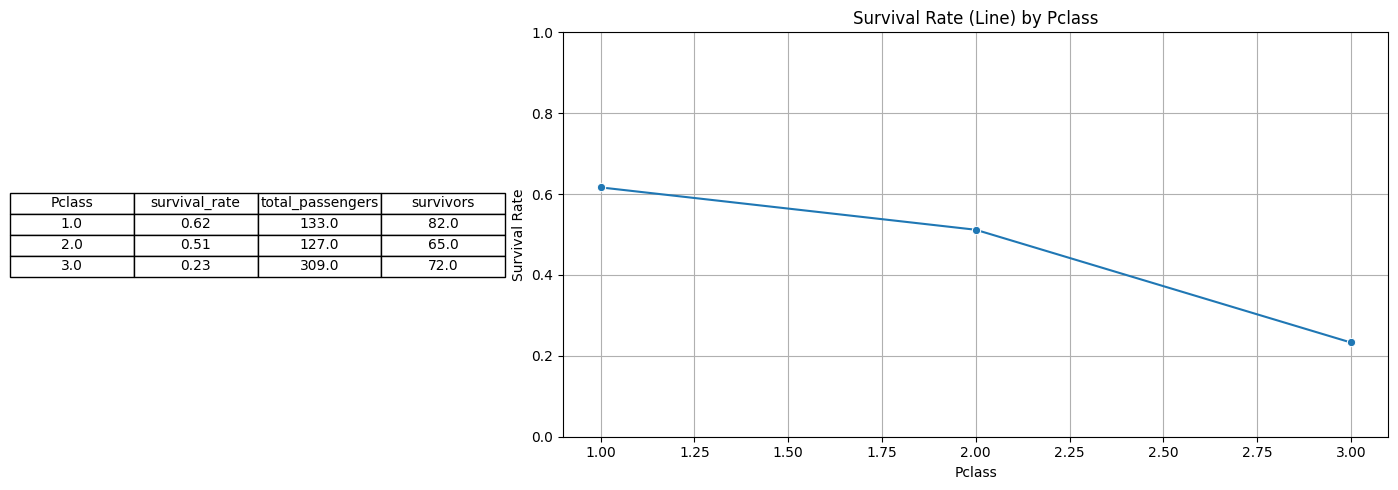

/var/folders/w8/9kcd5rnj58g541l7ydykcn_40000gn/T/ipykernel_35032/80266870.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(feature_col)[target_col]


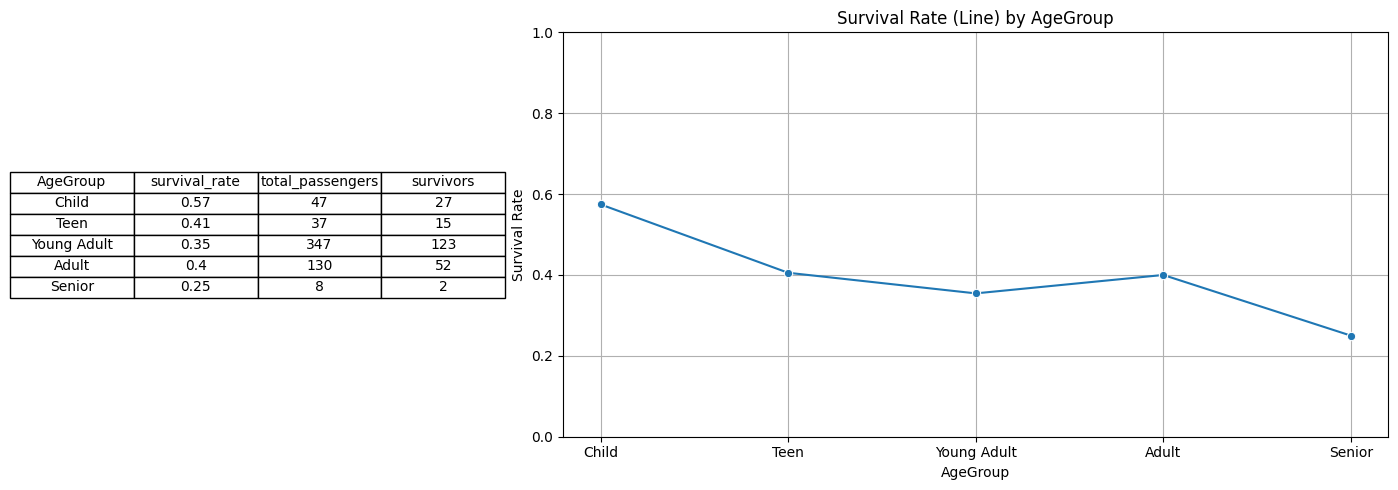

/var/folders/w8/9kcd5rnj58g541l7ydykcn_40000gn/T/ipykernel_35032/80266870.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(feature_col)[target_col]


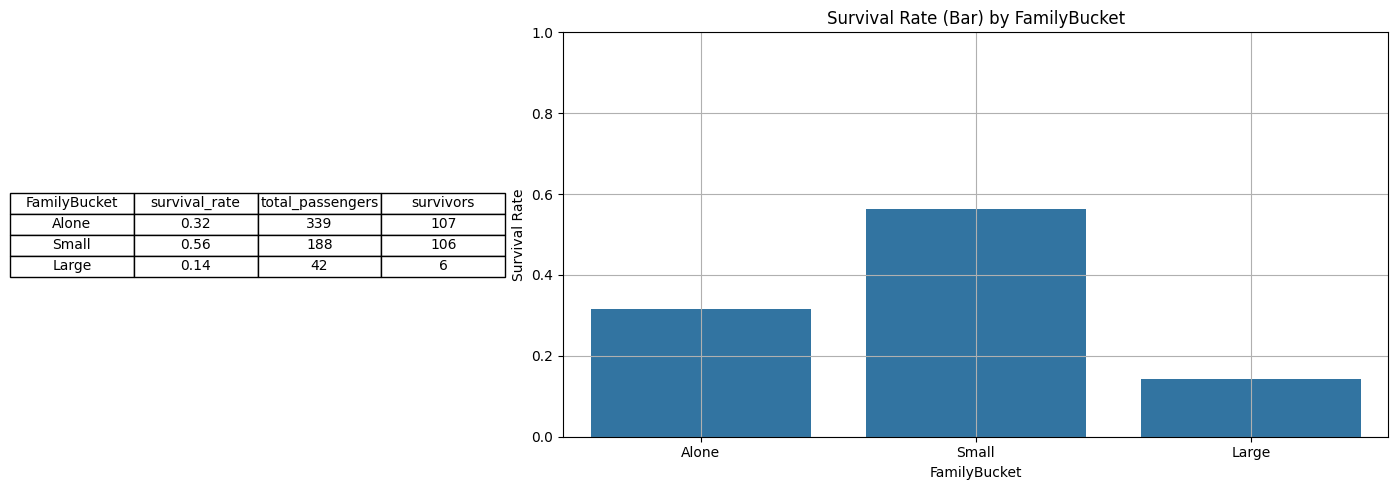

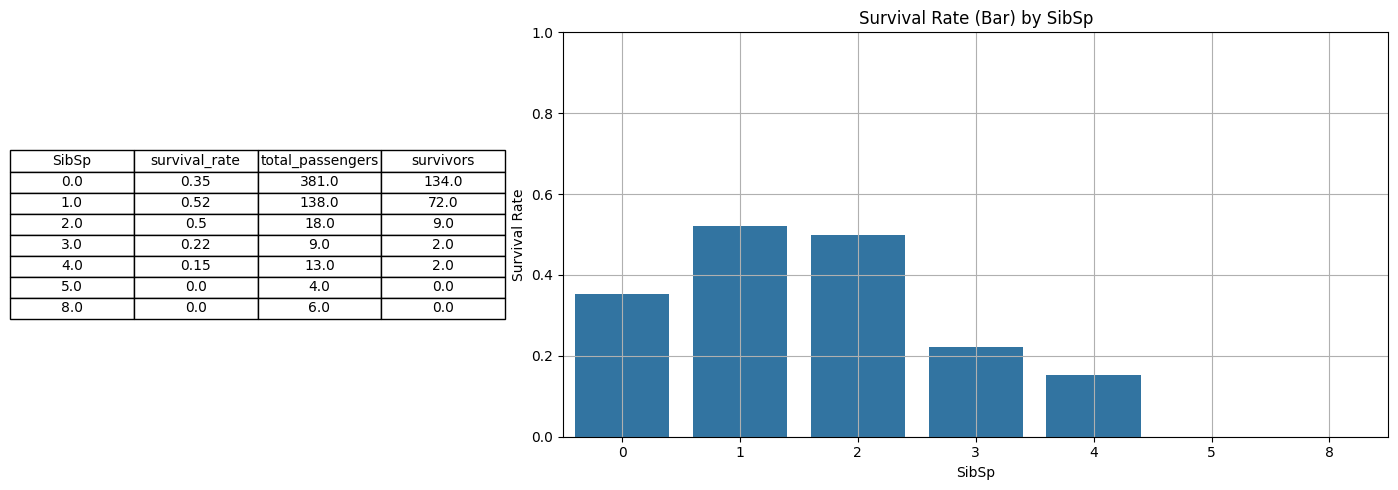

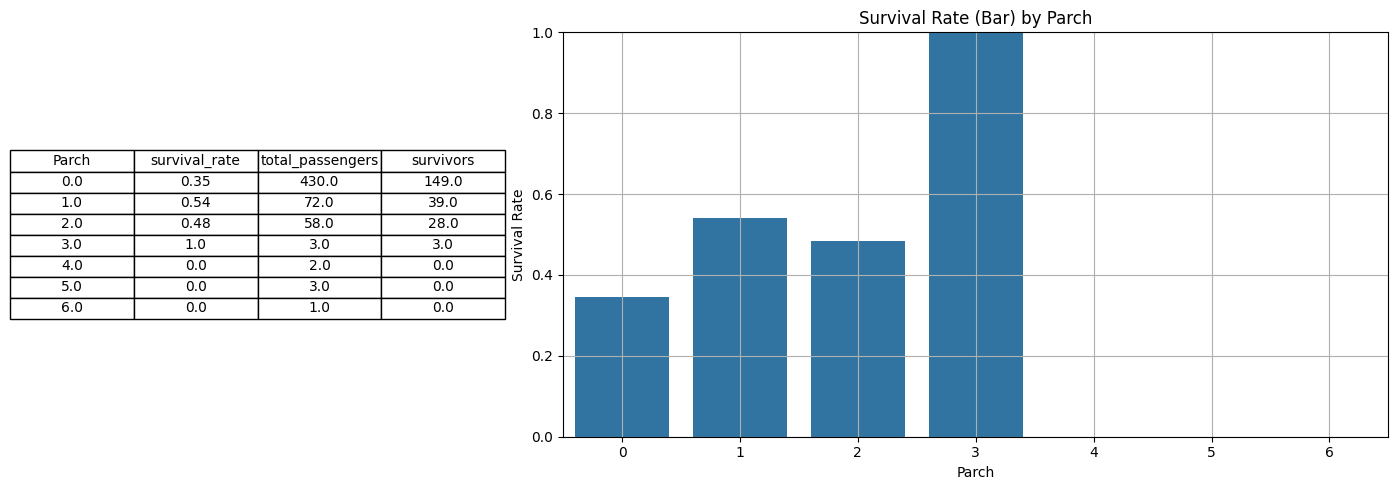

In [42]:
def analyze_feature_survival(df, feature_col, target_col):
    """
    Groups by a feature, aggregates survival metrics, and shows table + bar/line plot.

    Line plot for ordinal features like AgeGroup and Pclass.
    Bar plot for nominal features like Sex, SibSp, Parch, etc.

    Args:
        df (pd.DataFrame): Input DataFrame
        feature_col (str): Feature to analyze
        target_col (str): Target column (default: 'Survived')
    """
    # Group + Aggregate
    summary_df = (
        df
        .groupby(feature_col)[target_col]
        .agg(
            survival_rate='mean',
            total_passengers='count',
            survivors='sum'
        )
        .reset_index()
    )

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 2]})

    # Table
    axes[0].axis('tight')
    axes[0].axis('off')
    table_data = summary_df.round(2)
    table = axes[0].table(cellText=table_data.values,
                          colLabels=table_data.columns,
                          loc='center',
                          cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    # Decide plot type
    if feature_col in ["AgeGroup", "Pclass"]:
        sns.lineplot(data=summary_df, x=feature_col, y='survival_rate', marker='o', ax=axes[1])
        axes[1].set_title(f"Survival Rate (Line) by {feature_col}")
    else:
        sns.barplot(data=summary_df, x=feature_col, y='survival_rate', ax=axes[1])
        axes[1].set_title(f"Survival Rate (Bar) by {feature_col}")

    axes[1].set_ylabel("Survival Rate")
    axes[1].set_ylim(0, 1)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_features = ["Pclass", "AgeGroup", "FamilyBucket", "SibSp", "Parch"]

for feature in plot_features:
    analyze_feature_survival(data_analysis, feature,target_col)

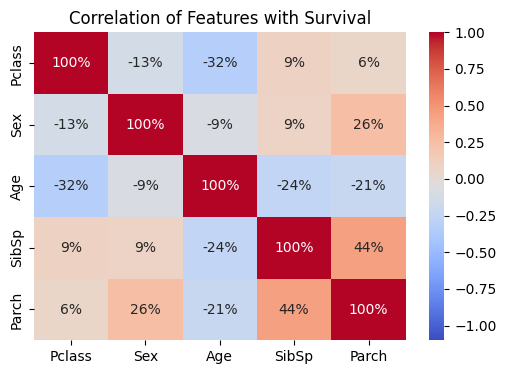

In [43]:
corr = X_train[model_features].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(data=corr,
            annot=True, 
            cmap='coolwarm',
            fmt=".0%",
            vmax=-1,
            vmin=1,
           )
plt.title("Correlation of Features with Survival")
plt.show()

In [44]:
def get_numerical_and_categorical_features(X_train):
    numerical_features = X_train.select_dtypes(exclude=['object']).columns.to_list()
    categorical_features = X_train.select_dtypes(include=['object']).columns.to_list()
    return (numerical_features,categorical_features)

num_ft,cate_ft = get_numerical_and_categorical_features(X_train)
print(num_ft)
print(cate_ft)

['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
[]


In [45]:
#Check for categorical features if they have either too few unique values or too many as both do not provide enough 
#signal to the model

def filter_categorical_features(X_train,categorical_features):
    filter_more_than_one = [f for f in categorical_features if X_train[f].nunique() > 1]
    unique_ratios = X_train[filter_more_than_one].nunique(dropna=True) / len(X_train)
    filtered_columns = unique_ratios[unique_ratios <= 0.99].index.to_list()
    return filtered_columns

categorical_ft_remove = filter_categorical_features(X_train,cate_ft)
print("features with too or too high unique values", categorical_ft_remove)

features with too or too high unique values []


In [46]:
# Check numerical featrues whose variance is too low as the featuure is too constant and will not provide signal
# to model

def filter_numerical_features(X_train,numerical_features):
    variances = X_train[model_features].var()
    # Find features with very low variance (e.g., less than 0.01)
    low_variance_features = variances[variances <0.01].index.tolist()
    return low_variance_features

numerical_low_var_ft_remove = filter_numerical_features(X_train,num_ft)
print("features with low variance " , numerical_low_var_ft_remove)

features with low variance  []


In [47]:
#features that tpp corelated do not provide additional lift to the model but confuse how would the model prioritize
# one feature over other if they provide same input. this method provide possible featrues that should be removed

def get_highly_correlated_pairs(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr = upper.stack().reset_index()
    high_corr.columns = ['feature1', 'feature2', 'corr']
    high_corr = high_corr[high_corr['corr'] >= threshold]
    #print(high_corr.sort_values(by='corr', ascending=False).reset_index(drop=True))
    return list(zip(high_corr['feature1'], high_corr['feature2']))

print(get_highly_correlated_pairs(X_train))

[]


In [48]:
#remove filtered categorical and low variance columns 
final_features =[i for i in list(X_train.columns) if i not in categorical_ft_remove + numerical_low_var_ft_remove]
#remove target column if any
model_features = [f for f in model_features if f != target_col]

def comparelist(final_ft, model_ft):
    set_final = set(final_ft)
    set_model = set(model_ft)
    return {
        "only in final" : list(set_final - set_model),
        "\n only in model" : list(set_model - set_final),
        "\n common" : list(set_model & set_final),
        "diff" : list(set_final ^ set_model)
    }

print(comparelist(final_features,model_features))
print(model_features)

{'only in final': ['PassengerId'], '\n only in model': [], '\n common': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'], 'diff': ['PassengerId']}
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']


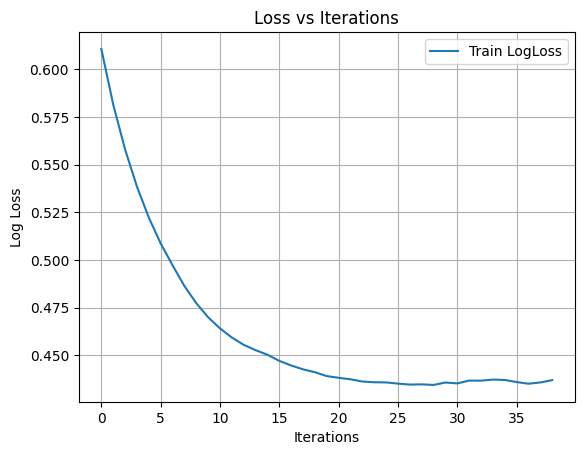

✅ Best Iteration: 28, with lowest validation logloss: 0.43447


In [49]:
xgb_model = XGBClassifier(
    n_estimators=50,
    max_depth=4,
    learning_rate=0.1,
    early_stopping_rounds=10,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(
    X_train[model_features],
    y_train,
    eval_set=[(X_val[model_features], y_val)],
    verbose=False,
)

evals_result = xgb_model.evals_result()
train_logloss = evals_result['validation_0']['logloss']
plt.plot(train_logloss, label='Train LogLoss')
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Loss vs Iterations")
plt.legend()
plt.grid(True)
plt.show()

best_iteration = train_logloss.index(min(train_logloss))
best_logloss = min(train_logloss)

print(f"✅ Best Iteration: {best_iteration}, with lowest validation logloss: {best_logloss:.5f}")


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.86       105
           1       0.86      0.68      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.82      0.82       179



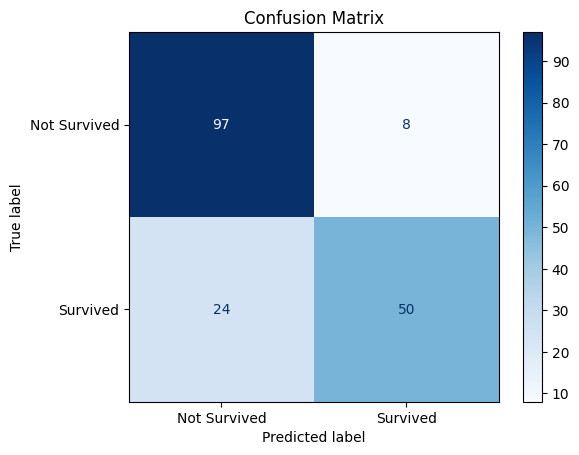

In [50]:
#y_test_pred = xgb_model.predict(X_test[model_features])
# Predict using only the best iteration
y_pred = xgb_model.predict(X_test[model_features], iteration_range=(0, xgb_model.best_iteration + 1))

print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Survived", "Survived"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

Train AUC (PR): 0.89499
Validation AUC (PR): 0.79966
Test AUC (PR): 0.86156


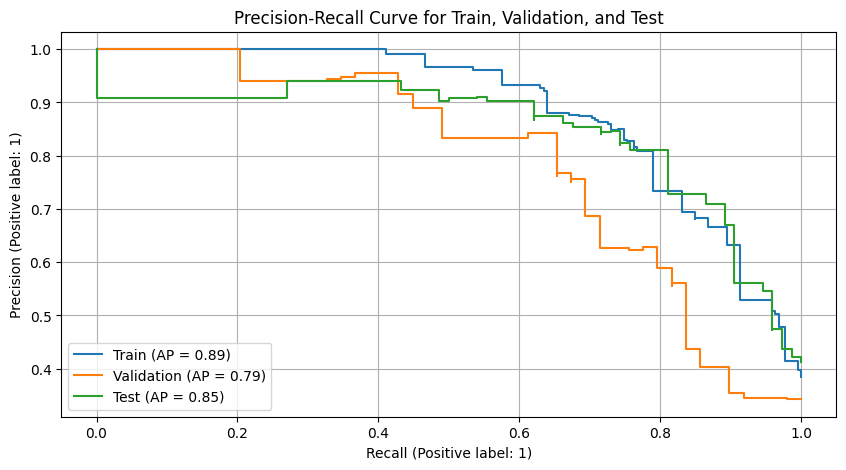

In [51]:
def evaluate_model(
    X_train: pd.DataFrame, y_train: pd.Series,
    X_val: pd.DataFrame, y_val: pd.Series,
    X_test: pd.DataFrame, y_test: pd.Series,
    model: XGBClassifier
):
    
    y_train_pred = model.predict_proba(X_train[xgb_model.get_booster().feature_names])[:, 1]
    y_val_pred = model.predict_proba(X_val[xgb_model.get_booster().feature_names])[:, 1]
    y_test_pred = model.predict_proba(X_test[xgb_model.get_booster().feature_names])[:, 1]

    train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_pred)
    val_precision, val_recall, _ = precision_recall_curve(y_val, y_val_pred)
    test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_pred)

    train_auc = round(auc(train_recall, train_precision), 5)
    val_auc = round(auc(val_recall, val_precision), 5)
    test_auc = round(auc(test_recall, test_precision), 5)

    # 4. Print AUCs
    print(f"Train AUC (PR): {train_auc}")
    print(f"Validation AUC (PR): {val_auc}")
    print(f"Test AUC (PR): {test_auc}")

    # 5. Plot all on same PR graph
    fig, ax = plt.subplots(figsize=(10, 5))
    PrecisionRecallDisplay.from_estimator(model, X_train[xgb_model.get_booster().feature_names], y_train, ax=ax, name="Train")
    PrecisionRecallDisplay.from_estimator(model, X_val[xgb_model.get_booster().feature_names], y_val, ax=ax, name="Validation")
    PrecisionRecallDisplay.from_estimator(model, X_test[xgb_model.get_booster().feature_names], y_test, ax=ax, name="Test")
    plt.title("Precision-Recall Curve for Train, Validation, and Test")
    plt.grid(True)
    plt.show()

evaluate_model(X_train,y_train,X_val,y_val,X_test,y_test, xgb_model)

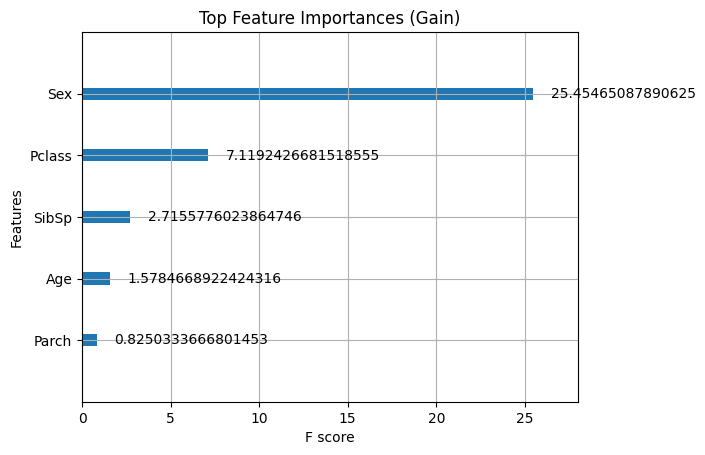

In [52]:
plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("Top Feature Importances (Gain)")
plt.show()

Train AUC (PR): 0.89499
Validation AUC (PR): 0.79966
Test AUC (PR): 0.86156


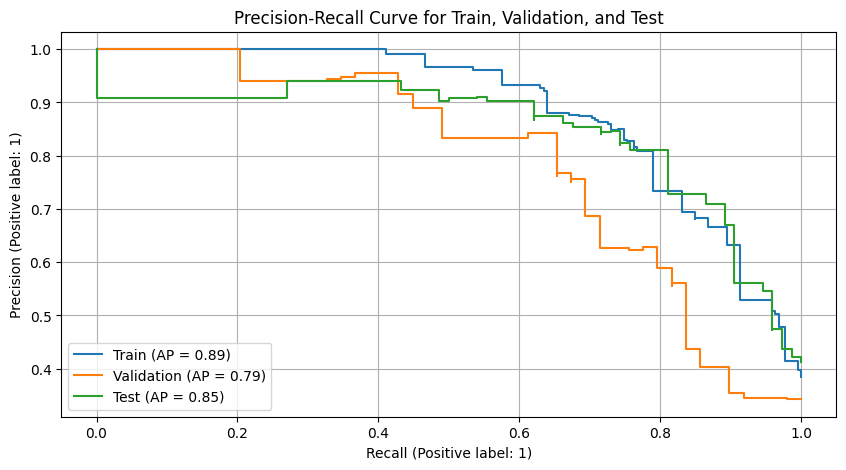

In [53]:
def evaluate_model(
    X_train: pd.DataFrame, y_train: pd.Series,
    X_val: pd.DataFrame, y_val: pd.Series,
    X_test: pd.DataFrame, y_test: pd.Series,
    model: XGBClassifier
):
    # 1. Predict probabilities (only positive class probabilities)
    y_train_pred = model.predict_proba(X_train[xgb_model.get_booster().feature_names])[:, 1]
    y_val_pred = model.predict_proba(X_val[xgb_model.get_booster().feature_names])[:, 1]
    y_test_pred = model.predict_proba(X_test[xgb_model.get_booster().feature_names])[:, 1]

    # 2. Compute precision, recall, thresholds
    train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_pred)
    val_precision, val_recall, _ = precision_recall_curve(y_val, y_val_pred)
    test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_pred)

    # 3. Calculate AUC for each
    train_auc = round(auc(train_recall, train_precision), 5)
    val_auc = round(auc(val_recall, val_precision), 5)
    test_auc = round(auc(test_recall, test_precision), 5)

    # 4. Print AUCs
    print(f"Train AUC (PR): {train_auc}")
    print(f"Validation AUC (PR): {val_auc}")
    print(f"Test AUC (PR): {test_auc}")

    # 5. Plot all on same PR graph
    fig, ax = plt.subplots(figsize=(10, 5))
    PrecisionRecallDisplay.from_estimator(model, X_train[xgb_model.get_booster().feature_names], y_train, ax=ax, name="Train")
    PrecisionRecallDisplay.from_estimator(model, X_val[xgb_model.get_booster().feature_names], y_val, ax=ax, name="Validation")
    PrecisionRecallDisplay.from_estimator(model, X_test[xgb_model.get_booster().feature_names], y_test, ax=ax, name="Test")
    plt.title("Precision-Recall Curve for Train, Validation, and Test")
    plt.grid(True)
    plt.show()

evaluate_model(X_train,y_train,X_val,y_val,X_test,y_test, xgb_model)

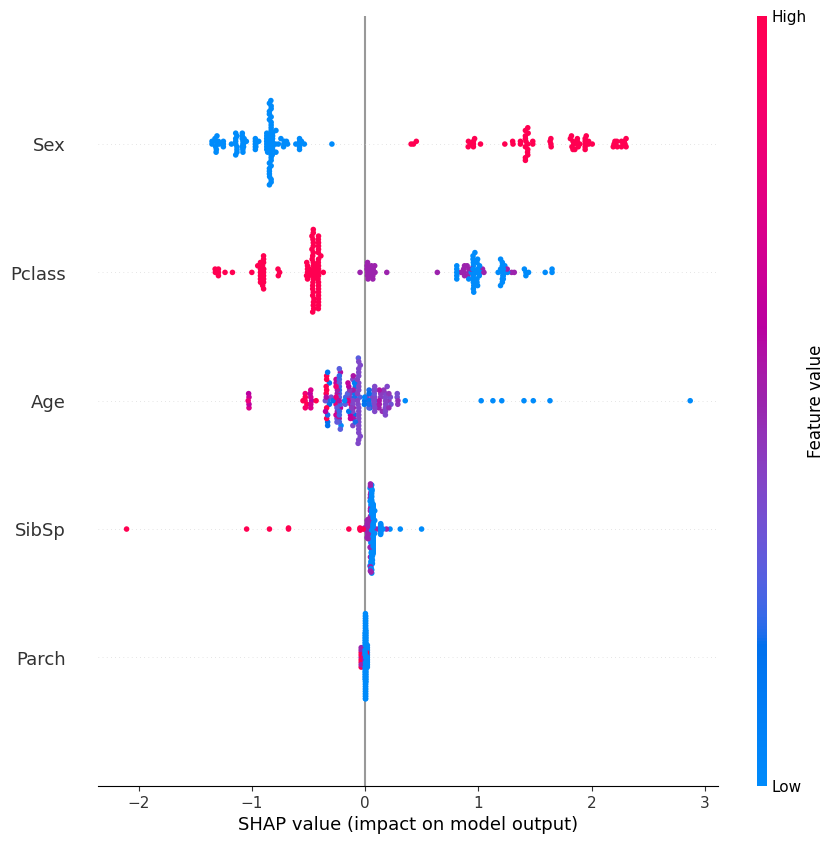

In [54]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test[xgb_model.get_booster().feature_names],y_test)
shap.plots.beeswarm(
    shap_values,
    max_display=30,
    plot_size=(10, 10),
    show=True
)

In [55]:
y_pred_test_data = xgb_model.predict(test_data[model_features])
submission = pd.DataFrame(
    {
        'PassengerId': test_data['PassengerId'],
        'Survived': y_pred_test_data
    }
)
print(submission.head())
submission.to_csv('submission.csv', index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
